# FoReS (Foundation Recommender System)
A recommender system for people that are new to the world of foundations and don't know where to start. Basically it recommends you a foundation shades based on your skin tone using Fitzpatrick scale.

In [1]:
%pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


## Import the necessary package

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from scipy import stats
from pycocotools import mask as maskUtils
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [78]:
using_colab = False

In [79]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib torch torchvision
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

In [80]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Data Exploration Analysis

In [81]:
# Count the number of train and val images
train_data = pd.read_csv('datasets/fitzpatrick/train.csv')
test_data = pd.read_csv('datasets/fitzpatrick/test.csv')
train_images = len(os.listdir("datasets/fitzpatrick/fairface/train/"))
test_images = len(os.listdir("datasets/fitzpatrick/fairface/val/"))

print(f"Train data: {len(train_data)}")
print(f"Test data: {len(test_data)}")
print(f"Train images: {train_images}")
print(f"Test images: {test_images}")

Train data: 35424
Test data: 4515
Train images: 35445
Test images: 4535


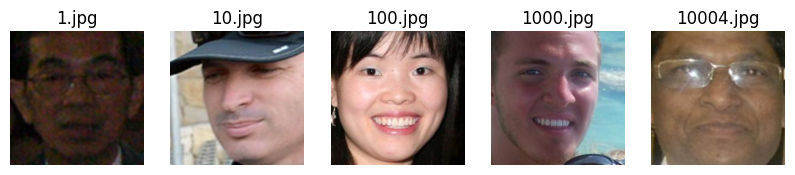

In [82]:
# Display 5 images from train folder
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    image = cv2.imread(f"datasets/fitzpatrick/fairface/train/{train_data.iloc[i]['file']}")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(train_data.iloc[i]['file'].split('/')[0])
    plt.axis('off')
plt.show()

## Images Preprocessing

In [83]:
df_train = pd.read_csv('datasets/fitzpatrick/train.csv')
df_test = pd.read_csv('datasets/fitzpatrick/test.csv')

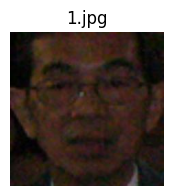

In [84]:
# Read all the images from the train.csv file
file_paths_train = df_train['file'].apply(lambda x: f"datasets/fitzpatrick/fairface/train/{x}").values
train_images = np.array([cv2.imread(file_path) for file_path in file_paths_train])

plt.figure(figsize=(2, 2))
plt.imshow(cv2.cvtColor(train_images[0], cv2.COLOR_BGR2RGB))
plt.title(df_train.iloc[0]['file'].split('/')[0])
plt.axis('off')
plt.show()

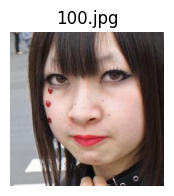

In [85]:
# Read all the images from the test.csv file
file_paths_test = df_test['file'].apply(lambda x: f"datasets/fitzpatrick/fairface/val/{x}").values
test_images = np.array([cv2.imread(file_path) for file_path in file_paths_test])

plt.figure(figsize=(2, 2))
plt.imshow(cv2.cvtColor(test_images[0], cv2.COLOR_BGR2RGB))
plt.title(df_test.iloc[0]['file'].split('/')[0])
plt.axis('off')
plt.show()

### Zoom & Center the Image

In [86]:
def zoom_center(img, zoom_factor=2):
    x_width = img.shape[1]
    y_height = img.shape[0]

    x1 = int(0.5 * x_width * (1 - 1 / zoom_factor))
    y1 = int(0.5 * y_height * (1 - 1 / zoom_factor))

    x2 = int(x_width - 0.5 * x_width * (1 - 1 / zoom_factor))
    y2 = int(y_height - 0.5 * y_height * (1 - 1 / zoom_factor))
    
    # Crop then scale
    cropped_img = img[y1:y2, x1:x2]
    return cv2.resize(cropped_img, None, fx=zoom_factor, fy=zoom_factor)

In [87]:
def display_image(img, title=None):
    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [88]:
# Perform the zooming operation
train_zoomed_images = np.array([zoom_center(img, 4) for img in train_images])

In [89]:
test_zoomed_images = np.array([zoom_center(img, 4) for img in test_images])

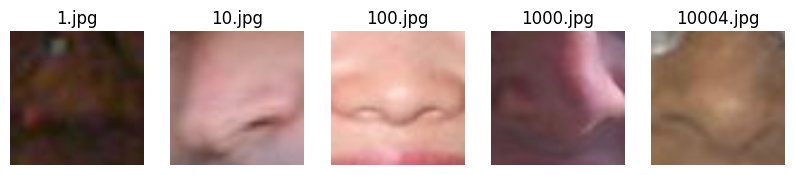

In [90]:
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(train_zoomed_images[i], cv2.COLOR_BGR2RGB))
    plt.title(df_train.iloc[i]['file'].split('/')[0])
    plt.axis('off')
plt.show()

### Extract the HSV and HSL Channels

#### Using Mean

In [91]:
def extract_hsl_mean(img):
    hsl = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h = np.mean(hsl[:, :, 0])
    s = np.mean(hsl[:, :, 1])
    l = np.mean(hsl[:, :, 2])
    return np.array([h, s, l])

def extract_hsv_mean(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h = np.mean(hsv[:, :, 0])
    s = np.mean(hsv[:, :, 1])
    v = np.mean(hsv[:, :, 2])
    return np.array([h, s, v])

#### Using Median

In [92]:
def extract_hsl_median(img):
    hsl = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h = np.median(hsl[:, :, 0])
    s = np.median(hsl[:, :, 1])
    l = np.median(hsl[:, :, 2])
    return np.array([h, s, l])

def extract_hsv_median(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h = np.median(hsv[:, :, 0])
    s = np.median(hsv[:, :, 1])
    v = np.median(hsv[:, :, 2])
    return np.array([h, s, v])

#### Using Mode

In [74]:
def extract_hsl_mode(img):
    hsl = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h = stats.mode(hsl[:, :, 0].flatten())[0]
    s = stats.mode(hsl[:, :, 1].flatten())[0]
    l = stats.mode(hsl[:, :, 2].flatten())[0]
    return np.array([h, s, l])

def extract_hsv_mode(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h = stats.mode(hsv[:, :, 0].flatten())[0]
    s = stats.mode(hsv[:, :, 1].flatten())[0]
    v = stats.mode(hsv[:, :, 2].flatten())[0]
    return np.array([h, s, v])

In [75]:
hsv_mean = extract_hsv_mean(train_zoomed_images[1])
hsl_mean = extract_hsl_mean(train_zoomed_images[1])

hsv_median = extract_hsv_median(train_zoomed_images[1])
hsl_median = extract_hsl_median(train_zoomed_images[1])

hsv_mode = extract_hsv_mode(train_zoomed_images[1])
hsl_mode = extract_hsl_mode(train_zoomed_images[1])

In [76]:
print(f"HSV mean: {hsv_mean}")
print(f"HSL mean: {hsl_mean}")

print(f"HSV median: {hsv_median}")
print(f"HSL median: {hsl_median}")

print(f"HSV mode: {hsv_mode}")
print(f"HSL mode: {hsl_mode}")

HSV mean: [ 46.37761081  66.84865274 182.81881776]
HSL mean: [ 46.49551578 159.47343351  71.17914939]
HSV median: [  4.  65. 190.]
HSL median: [  4. 165.  74.]
HSV mode: [  2  63 208]
HSL mode: [  2 184  77]


In [67]:
hsv_mean_train = np.array([extract_hsv_mean(img) for img in train_zoomed_images])
hsl_mean_train = np.array([extract_hsl_mean(img) for img in train_zoomed_images])

hsv_median_train = np.array([extract_hsv_median(img) for img in train_zoomed_images])
hsl_median_train = np.array([extract_hsl_median(img) for img in train_zoomed_images])

hsv_mode_train = np.array([extract_hsv_mode(img) for img in train_zoomed_images])
hsl_mode_train = np.array([extract_hsl_mode(img) for img in train_zoomed_images])

In [68]:
hsv_mean_test = np.array([extract_hsv_mean(img) for img in test_zoomed_images])
hsl_mean_test = np.array([extract_hsl_mean(img) for img in test_zoomed_images])

hsv_median_test = np.array([extract_hsv_median(img) for img in test_zoomed_images])
hsl_median_test = np.array([extract_hsl_median(img) for img in test_zoomed_images])

hsv_mode_test = np.array([extract_hsv_mode(img) for img in test_zoomed_images])
hsl_mode_test = np.array([extract_hsl_mode(img) for img in test_zoomed_images])

In [73]:
hsv_mean_train.shape

(35424, 3)

### Append the Extracted Channels to the Dataframe

In [98]:
# Append the extracted features to the train and test dataframes respectively
# Train data
df_train['hsv_mean_h'] = hsv_mean_train[:, 0]
df_train['hsv_mean_s'] = hsv_mean_train[:, 1]
df_train['hsv_mean_v'] = hsv_mean_train[:, 2]

df_train['hsl_mean_h'] = hsl_mean_train[:, 0]
df_train['hsl_mean_s'] = hsl_mean_train[:, 1]
df_train['hsl_mean_l'] = hsl_mean_train[:, 2]

df_train['hsv_median_h'] = hsv_median_train[:, 0]
df_train['hsv_median_s'] = hsv_median_train[:, 1]
df_train['hsv_median_v'] = hsv_median_train[:, 2]

df_train['hsl_median_h'] = hsl_median_train[:, 0]
df_train['hsl_median_s'] = hsl_median_train[:, 1]
df_train['hsl_median_l'] = hsl_median_train[:, 2]

df_train['hsv_mode_h'] = hsv_mode_train[:, 0]
df_train['hsv_mode_s'] = hsv_mode_train[:, 1]
df_train['hsv_mode_v'] = hsv_mode_train[:, 2]

df_train['hsl_mode_h'] = hsl_mode_train[:, 0]
df_train['hsl_mode_s'] = hsl_mode_train[:, 1]
df_train['hsl_mode_l'] = hsl_mode_train[:, 2]

# Test data
df_test['hsv_mean_h'] = hsv_mean_test[:, 0]
df_test['hsv_mean_s'] = hsv_mean_test[:, 1]
df_test['hsv_mean_v'] = hsv_mean_test[:, 2]

df_test['hsl_mean_h'] = hsl_mean_test[:, 0]
df_test['hsl_mean_s'] = hsl_mean_test[:, 1]
df_test['hsl_mean_l'] = hsl_mean_test[:, 2]

df_test['hsv_median_h'] = hsv_median_test[:, 0]
df_test['hsv_median_s'] = hsv_median_test[:, 1]
df_test['hsv_median_v'] = hsv_median_test[:, 2]

df_test['hsl_median_h'] = hsl_median_test[:, 0]
df_test['hsl_median_s'] = hsl_median_test[:, 1]
df_test['hsl_median_l'] = hsl_median_test[:, 2]

df_test['hsv_mode_h'] = hsv_mode_test[:, 0]
df_test['hsv_mode_s'] = hsv_mode_test[:, 1]
df_test['hsv_mode_v'] = hsv_mode_test[:, 2]

df_test['hsl_mode_h'] = hsl_mode_test[:, 0]
df_test['hsl_mode_s'] = hsl_mode_test[:, 1]
df_test['hsl_mode_l'] = hsl_mode_test[:, 2]

In [99]:
# Show the dataframe
df_train.head()

,file,age,gender,race,phototype,hsv_mean_h,hsv_mean_s,hsv_mean_v,hsl_mean_h,hsl_mean_s,...,hsv_median_v,hsl_median_h,hsl_median_s,hsl_median_l,hsv_mode_h,hsv_mode_s,hsv_mode_v,hsl_mode_h,hsl_mode_s,hsl_mode_l
0,1.jpg,50-59,Male,East Asian,III,19.829241,137.944695,59.733877,19.805764,43.699139,...,59.0,11.0,43.0,94.0,8,125,60,13,42,85
1,10.jpg,30-39,Male,Middle Eastern,V,46.377611,66.848653,182.818818,46.495516,159.473434,...,190.0,4.0,165.0,74.0,2,63,208,2,184,77
2,100.jpg,20-29,Female,East Asian,III,18.022879,77.726981,227.602320,19.009347,193.497987,...,231.0,7.0,196.0,150.0,7,68,239,7,207,117
3,1000.jpg,30-39,Male,White,I & II,160.481166,85.828245,118.044105,160.467235,98.868762,...,103.0,173.0,84.0,56.0,174,90,94,174,76,55
4,10004.jpg,40-49,Male,Indian,V,12.648039,101.791016,141.452208,12.642140,113.252232,...,139.0,12.0,110.0,67.0,12,102,136,12,100,65


In [100]:
df_test.head()

,file,age,gender,race,phototype,hsv_mean_h,hsv_mean_s,hsv_mean_v,hsl_mean_h,hsl_mean_s,...,hsv_median_v,hsl_median_h,hsl_median_s,hsl_median_l,hsv_mode_h,hsv_mode_s,hsv_mode_v,hsl_mode_h,hsl_mode_s,hsl_mode_l
0,100.jpg,20-29,Female,East Asian,III,6.106924,59.707769,220.173609,6.086934,195.800961,...,227.0,6.0,204.0,117.0,6,44,245,6,209,128
1,1000.jpg,20-29,Male,Latino_Hispanic,IV,13.975426,145.924506,102.479791,13.968411,76.195093,...,112.5,13.0,82.0,94.0,13,255,125,13,104,255
2,10000.jpg,20-29,Female,East Asian,III,11.909180,68.051319,239.855110,11.898617,208.674386,...,243.0,12.0,213.0,173.0,11,28,246,11,235,168
3,10001.jpg,20-29,Female,Southeast Asian,V,6.953524,99.132972,150.359495,6.961077,121.588489,...,162.0,7.0,131.0,69.0,7,99,174,7,140,65
4,10004.jpg,20-29,Male,Southeast Asian,V,17.130521,138.675044,200.580835,17.125558,149.406948,...,206.0,17.0,149.0,149.0,17,139,255,17,149,255


### Save the Dataframe

In [111]:
# Save the dataframe to a csv file
df_train.to_csv('datasets/fitzpatrick/new_train.csv', index=False)
df_test.to_csv('datasets/fitzpatrick/new_test.csv', index=False)

In [112]:
# Read the new csv files
df_new_train = pd.read_csv('datasets/fitzpatrick/new_train.csv')
df_new_test = pd.read_csv('datasets/fitzpatrick/new_test.csv')

In [113]:
print(f"Shape of new train data: {df_new_train.shape}")
print(f"Shape of new test data: {df_new_test.shape}")

Shape of new train data: (35424, 23)
Shape of new test data: (4515, 23)
